## Application of Logistic Regression for classifying English articles into fiction and non-fiction category

In [3]:
# NLTK is a popular library used for analysing texts
# The brown corpus dataset is present inside this library
import nltk
from nltk.corpus import brown
nltk.download('brown')
import pandas as pd
from sklearn import preprocessing
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package brown to /home/nag2mani/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [4]:
# Details of all the information contained in the NLTK brown corpus
help(brown)

Help on LazyCorpusLoader in module nltk.corpus.util object:

brown = class CategorizedTaggedCorpusReader(nltk.corpus.reader.api.CategorizedCorpusReader, TaggedCorpusReader)
 |  brown(*args, **kwargs)
 |  
 |  A reader for part-of-speech tagged corpora whose documents are
 |  divided into categories based on their file identifiers.
 |  
 |  Method resolution order:
 |      CategorizedTaggedCorpusReader
 |      nltk.corpus.reader.api.CategorizedCorpusReader
 |      TaggedCorpusReader
 |      nltk.corpus.reader.api.CorpusReader
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args, **kwargs)
 |      Initialize the corpus reader.  Categorization arguments
 |      (``cat_pattern``, ``cat_map``, and ``cat_file``) are passed to
 |      the ``CategorizedCorpusReader`` constructor.  The remaining arguments
 |      are passed to the ``TaggedCorpusReader``.
 |  
 |  tagged_paras(self, fileids=None, categories=None, tagset=None)
 |      :return: the given file(s) as 

In [5]:
# List of all text categories present in the brown corpus
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [6]:
# List of all articles within the 'news' category
brown.fileids('news')

['ca01',
 'ca02',
 'ca03',
 'ca04',
 'ca05',
 'ca06',
 'ca07',
 'ca08',
 'ca09',
 'ca10',
 'ca11',
 'ca12',
 'ca13',
 'ca14',
 'ca15',
 'ca16',
 'ca17',
 'ca18',
 'ca19',
 'ca20',
 'ca21',
 'ca22',
 'ca23',
 'ca24',
 'ca25',
 'ca26',
 'ca27',
 'ca28',
 'ca29',
 'ca30',
 'ca31',
 'ca32',
 'ca33',
 'ca34',
 'ca35',
 'ca36',
 'ca37',
 'ca38',
 'ca39',
 'ca40',
 'ca41',
 'ca42',
 'ca43',
 'ca44']

In [7]:
# List of the first 20 tagged words in article number 'ca44'
# As you can see, each article is divided into individual words (tokenization), 
# and for each word, the corresponging Part of Speech (POS) tag is specified.
# You can use the functions defined later on to convert these POS tags to universal tags that are easy to understand.

print(type(brown.tagged_words('ca44')))
print(len(brown.tagged_words('ca44')))
print(brown.tagged_words('ca44')[0:20])

<class 'nltk.corpus.reader.tagged.TaggedCorpusView'>
2277
[('Every', 'AT'), ('library', 'NN'), ('borrower', 'NN'), (',', ','), ('or', 'CC'), ('at', 'IN'), ('least', 'AP'), ('those', 'DTS'), ('whose', 'WP$'), ('taste', 'NN'), ('goes', 'VBZ'), ('beyond', 'IN'), ('the', 'AT'), ('five-cent', 'JJ'), ('fiction', 'NN'), ('rentals', 'NNS'), (',', ','), ('knows', 'VBZ'), ('what', 'WDT'), ('it', 'PPS')]


The Fictometer algorithm is based on the Part of Speech (POS) tags in a text. For a given input text, it first counts the number adverbs, adjectives, and pronounds in the text and uses it as an input to the Logistic Regression algorithm to do the classification.

We will be using the Brown corpus dataset for this work, and this corpus has both the text as well as the POS tags (added by human experts). However, the POS tags present in this corpus are finer, meaning adjectives can be further sub-divided into finer categories. But for our analysis, we only need the high level tags. And so the first step is to convert/group the finer tags into high level tags, which we do through the functions defined below.

In [8]:
# Define functions to count the number of POS tags in the text.

# This function counts the number of adjectives
def n_adj(text):
    adj=0
    for i in text:
        if i[0] == 'J':
            adj=adj+1
    return adj

# This function counts the number of nouns
def n_noun(text):
    noun=0
    for i in text:
        if ((i[0] == 'N') and (i[1] != 'C')):
            noun=noun+1
    return noun

# This function counts the number of verbs
def n_verb(text):
    verb=0
    for i in text:
        if i[0] == 'V':
            verb=verb+1
    return verb

# This function counts the number of pronouns
def n_pronoun(text):
    pronoun=0
    for i in text:
        if (i[0] == 'P') or (i[:3] in ['WP$','WPO','WPS']):
            pronoun=pronoun+1
    return pronoun

# This function counts the number of adverbs
def n_adv(text):
    adv=0
    for i in text:
        if (i[0] == 'R') or (i[:3] in ['WRB']):
            adv=adv+1
    return adv

# This function outputs the universal high level tag using a finer tag as input
def func_utag(tag):
    if tag[0] == 'J' or tag == 'ADJ':
        utag='ADJ'
    elif ((tag[0] == 'N') and (tag[1] != 'C')) or tag == 'NOUN':
        utag='NOUN'
    elif tag[0] == 'V' or tag == 'VERB':
        utag='VERB'
    elif (tag[0] == 'P') or (tag[:3] in ['WP$','WPO','WPS']) or tag == 'PRON':
        utag='PRON'
    elif (tag[0] == 'R') or (tag[:3] in ['WRB']) or tag == 'ADV':
        utag='ADV'
    else:
        utag='unknown'
    return utag

# This function outputs True or False depending on whether the input tag is one of the 5 high level universal tags or not.
def func_is5tag(tag):
    if tag in ['ADJ','ADV','NOUN','PRON','VERB']:
        is5tag=True
    else:
        is5tag=False
    return is5tag

In [9]:
# This creates an empty dataframe with the defined columns
brownpostable=pd.DataFrame(columns=['category','filename','ADJ','ADV','NOUN','VERB','PRON','RADJPRON','RADVADJ'])

In [13]:
# Take each article from the Brown corpus, count the number of each universal POS tag in the article, 
# and populate the DataFrame

for i in brown.categories():
  # This loop iterates over all the 15 categories of articles present in the Brown corpus
  
    for j in brown.fileids(categories=i):
      # This loop iterates over all the articles present in the chosen category

        taggedwords=brown.tagged_words(j)
        taglist=[]
        for k in taggedwords:
          # This loop iterates over all the tagged words in the chosen article

            taglist.append(k[1])
        adj=n_adj(taglist) # Count the number of adjectives in the article
        adv=n_adv(taglist) # Count the number of adverbs in the article
        noun=n_noun(taglist) # Count the number of nouns in the article
        verb=n_verb(taglist) # Count the number of verbs in the article
        pronoun=n_pronoun(taglist) # Count the number of pronouns in the article

        # Append the above information for each article to the DataFrame
        ap = {'category' : i,'filename' : j, 'ADJ' : int(adj), 'ADV' : int(adv), 'NOUN' : int(noun), 'VERB' : int(verb), 'PRON' : int(pronoun)}
        df_dictionary = pd.DataFrame([ap])
        brownpostable = pd.concat([brownpostable, df_dictionary], ignore_index=True)
        # brownpostable=brownpostable.append(ap,ignore_index=True)

In [14]:
brownpostable

,category,filename,ADJ,ADV,NOUN,VERB,PRON,RADJPRON,RADVADJ
0,adventure,cn01,72,134,390,321,329,NaN,NaN
1,adventure,cn02,71,144,423,328,312,NaN,NaN
2,adventure,cn03,58,98,487,352,219,NaN,NaN
3,adventure,cn04,121,116,466,320,242,NaN,NaN
4,adventure,cn05,74,142,363,301,339,NaN,NaN
...,...,...,...,...,...,...,...,...,...
995,science_fiction,cm02,128,116,463,255,177,NaN,NaN
996,science_fiction,cm03,109,135,415,223,205,NaN,NaN
997,science_fiction,cm04,125,134,422,265,244,NaN,NaN
998,science_fiction,cm05,183,84,531,247,181,NaN,NaN


In [15]:
# Compute the ratio of Adjectives to Pronouns, and the ratio of Adverbs to Adjectives in each article 
# and populate the last 2 columns of the DataFrame

for i in range(len(brownpostable)):
    adj=brownpostable.ADJ.iloc[i]
    adv=brownpostable.ADV.iloc[i]
    pronoun=brownpostable.PRON.iloc[i]
    brownpostable.RADJPRON.iloc[i]=adj/pronoun
    brownpostable.RADVADJ.iloc[i]=adv/adj

In [16]:
brownpostable

,category,filename,ADJ,ADV,NOUN,VERB,PRON,RADJPRON,RADVADJ
0,adventure,cn01,72,134,390,321,329,0.218845,1.861111
1,adventure,cn02,71,144,423,328,312,0.227564,2.028169
2,adventure,cn03,58,98,487,352,219,0.26484,1.689655
3,adventure,cn04,121,116,466,320,242,0.5,0.958678
4,adventure,cn05,74,142,363,301,339,0.218289,1.918919
...,...,...,...,...,...,...,...,...,...
995,science_fiction,cm02,128,116,463,255,177,0.723164,0.90625
996,science_fiction,cm03,109,135,415,223,205,0.531707,1.238532
997,science_fiction,cm04,125,134,422,265,244,0.512295,1.072
998,science_fiction,cm05,183,84,531,247,181,1.01105,0.459016


In [17]:
# Re-categorise the Brown corpus categories as fiction and non-fiction.
# 5 categories are identified as fiction, 5 as non-fiction and the remaining 5 are dropped due to ambiguity.

brown2=brownpostable.copy()
for i in ['news','reviews','government','learned','hobbies']:
    brown2=brown2.replace(to_replace=i,value='nonfiction')

for i in ['fiction','mystery','science_fiction','adventure','romance']:
    brown2=brown2.replace(to_replace=i,value='fiction')
    
index_names=brown2[(brown2['category'] != 'fiction') & (brown2['category'] != 'nonfiction')].index
brown2.drop(index_names,inplace=True)

In [18]:
brown2.drop(columns=['filename','PRON','ADJ','ADV','NOUN','VERB'],inplace=True)

In [19]:
brown2

,category,RADJPRON,RADVADJ
0,fiction,0.218845,1.861111
1,fiction,0.227564,2.028169
2,fiction,0.264840,1.689655
3,fiction,0.500000,0.958678
4,fiction,0.218289,1.918919
...,...,...,...
995,fiction,0.723164,0.906250
996,fiction,0.531707,1.238532
997,fiction,0.512295,1.072000
998,fiction,1.011050,0.459016


<Axes: xlabel='RADVADJ', ylabel='RADJPRON'>

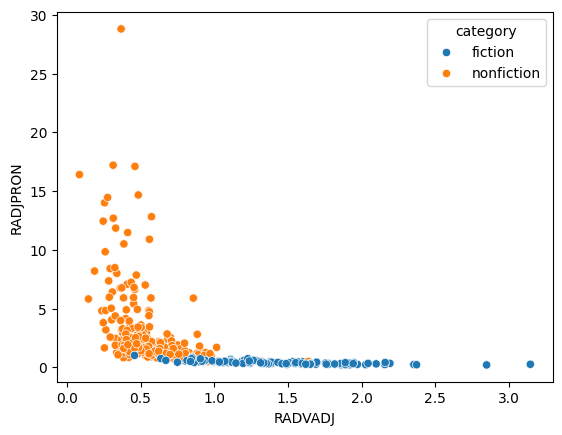

In [20]:
sns.scatterplot(data=brown2, hue='category', x='RADVADJ', y='RADJPRON')

In [21]:
# replace the text labels by numbers
brown3=brown2.replace(to_replace='nonfiction',value='0')
brown3=brown3.replace(to_replace='fiction',value='1')

In [22]:
brown3

,category,RADJPRON,RADVADJ
0,1,0.218845,1.861111
1,1,0.227564,2.028169
2,1,0.264840,1.689655
3,1,0.500000,0.958678
4,1,0.218289,1.918919
...,...,...,...
995,1,0.723164,0.906250
996,1,0.531707,1.238532
997,1,0.512295,1.072000
998,1,1.011050,0.459016


In [23]:
x=brown3.drop(columns=['category'])
y=brown3.category

In [24]:
x

,RADJPRON,RADVADJ
0,0.218845,1.861111
1,0.227564,2.028169
2,0.264840,1.689655
3,0.500000,0.958678
4,0.218289,1.918919
...,...,...
995,0.723164,0.906250
996,0.531707,1.238532
997,0.512295,1.072000
998,1.011050,0.459016


In [25]:
y

0      1
1      1
2      1
3      1
4      1
      ..
995    1
996    1
997    1
998    1
999    1
Name: category, Length: 648, dtype: object

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(x_train,y_train)

LogisticRegression()

In [27]:
# Training accuracy

y_pred=logreg.predict(x_train)
accuracy = metrics.accuracy_score(y_train,y_pred)
print("Training Accuracy : ",accuracy)

Training Accuracy :  0.9633204633204633


In [28]:
# Testing accuracy

y_pred=logreg.predict(x_test)
accuracy = metrics.accuracy_score(y_test,y_pred)
print("Testing Accuracy : ", accuracy)

Testing Accuracy :  0.9615384615384616


In [29]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[79,  3],
       [ 2, 46]])

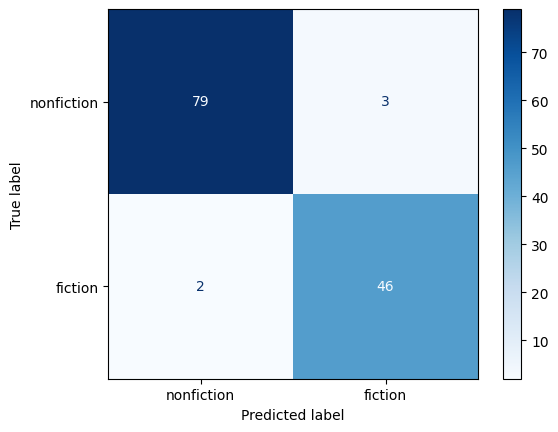

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['nonfiction', 'fiction'])
disp.plot(cmap=plt.cm.Blues)  # plot the confusion matrix
plt.show()  # show the plot

In [31]:
# Parameter values of Logistic Regression after training
print(logreg.intercept_)
print(logreg.coef_)

[2.31307627]
[[-5.11482301  2.08223243]]
